## Increasing Profit - The Music Shop

We will be working with the Chinook database. It contains information about a fictional digital music shop - kind of like a mini-iTunes store.

The Chinook database contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases. This information is contained in eleven tables. Like with our Factbook database, a schema diagram will help us understand the available columns and the structure of the data. 
The database and the schema diagram are available __[here](http://www.sqlitetutorial.net/sqlite-sample-database/)__

We will explore below questions which will help business take decisions for:
1. Which new albums should be considered for purchase from the US genre to increase profit?
2. How are employees performing?
3. Which countries have good opportunity for sales?
4. Should more albums be purchased instead of individual tracks?
5. Which artists are used the most in playlists? Which are the highest selling artists in US?
6. How many tracks have been purchased atleast once?
7. What is the range of tracks in the store and their sales popularity?
8. How does popularity vary for protected vs non-protected media types?


### Summary of Results
1. Analyzing US genre sales, new albums by Red Tone (Punk), Slim Jim Bites (Blues) and Meteor and the Girls (Pop) should be purchased. Rock and Latin can be considered for future purchases because of high popularity.
2. While there is a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee), the difference roughly corresponds with the differences in their hiring dates.
3. Czech Republic, USA and India have good opportunity for sales. As the sample size is not large enough to give us high confidence, starting off with small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers would be a good idea.
4. Album purchases is recommended instead of purchasing only select tracks from albums.
5. Iron Maiden is by far the most popular artist in playlists and has the maximum number of purchases.
6. 56.63% of tracks have been purchased at least once.
7. The available range of tracks is not closely reflective of popularity. There are more tracks of Latin and Rock music than it can sell. It is recommended to look into the selections of tracks in these particular types as some of the currect selections are not popular with the customer.
8. Unprotected media types sell more than protected media types.

### Read Data

In [1]:
#Import Required Libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Create Helper Functions
We will create three functions in python to save time.

In [2]:
#Location of the database
db = "chinook.db"

In [3]:
#Function that takes a SQL query as an argument and returns a pandas dataframe of that query
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

In [4]:
#Function that takes a SQL command as an argument and executes it using the sqlite module
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None #SQLite will autocommit any changes
        conn.execute(c)

In [5]:
#Function thats runs a query to return a list of all tables and views in the database
def show_tables():
    q = '''SELECT 
            name,
            type
         FROM sqlite_master
         WHERE type IN ("table", "view");'''
    return run_query(q)

In [6]:
show_tables()

,name,type
0,albums,table
1,sqlite_sequence,table
2,artists,table
3,customers,table
4,employees,table
5,genres,table
6,invoices,table
7,invoice_items,table
8,media_types,table
9,playlists,table


### Selecting New Albums to Purchase
The Chinook record store has just signed a deal with a new record label, and we have to select the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

| Artist Name | Genre |
| --- | --- |
| Regal | Hip-Hop |
| Red Tone | Punk |
| Meteor and the Girls | Pop |
| Slim Jim Bites | Blues |

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

We need to write a query to find out which genres sell the most tracks in the USA. Looking at the popularity of the tracks sold the most, we can recommend which three albums should be added to the store.

In [7]:
#Each genre with the number of tracks sold in the USA: in absolute numbers and in percentages
genre_tracks_sold = '''WITH cust_USA AS
(
SELECT * FROM invoice_items il 
            INNER JOIN invoices i ON il.invoiceid = i.invoiceid
            INNER JOIN customers c ON i.customerid = c.customerid
            WHERE c.country = "USA"
)
SELECT 
    g.name genre, 
    SUM(cust.quantity) tracks_sold, 
    ROUND(CAST(SUM(cust.quantity) as FLOAT) / (select count(*) FROM cust_USA) * 100, 2) percentage_sold
FROM cust_USA cust
    INNER JOIN tracks t ON cust.trackid = t.trackid
    INNER JOIN genres g ON t.genreid = g.genreid
GROUP BY 1
ORDER BY 2 DESC
'''
run_query(genre_tracks_sold)

,genre,tracks_sold,percentage_sold
0,Rock,157,31.78
1,Latin,91,18.42
2,Metal,64,12.96
3,Alternative & Punk,50,10.12
4,Jazz,22,4.45
5,Blues,15,3.04
6,TV Shows,14,2.83
7,R&B/Soul,12,2.43
8,Classical,8,1.62
9,Comedy,8,1.62


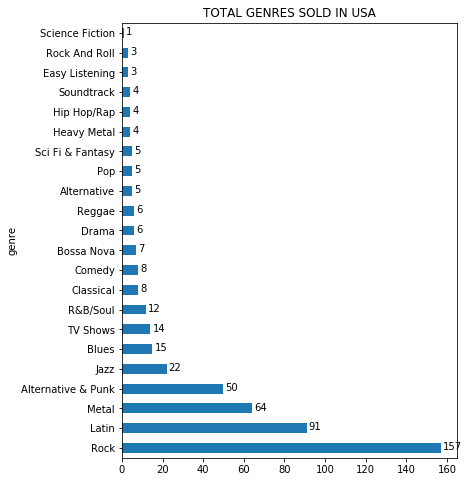

In [8]:
genre_sales_usa = run_query(genre_tracks_sold)
genre_sales_usa.set_index("genre",drop=True,inplace=True)

#Plot data using a bar plot
ax = genre_sales_usa.plot(kind = 'barh', y = "tracks_sold", figsize = (6,8), title = 'TOTAL GENRES SOLD IN USA', legend = False)
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_x() + p.get_width(), p.get_y()), xytext=(2, 3), textcoords='offset points')
    

Based on the sales of tracks across different genres in the USA, we should purchase the new albums by the following artists:

1. Red Tone (Punk)
2. Slim Jim Bites (Blues)
3. Meteor and the Girls (Pop)

Even though the above three generes account for around 14%, we can suggest considering Rock or Latin generes in the future as they seem to be very popular.

### Analyzing Employee Sales Performance
Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We have to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [9]:
#Total dollar amount of sales assigned to each sales support agent within the company 
agent_sale = '''SELECT e.hiredate, e.firstname || " " || e.lastname Emp_name, SUM(i.total) Sale
FROM employees e 
    LEFT JOIN customers c ON e.employeeid = c.supportrepid
    INNER JOIN invoices i ON c.customerid = i.customerid
GROUP BY 1,2
ORDER BY 2 DESC'''
run_query(agent_sale)

,HireDate,Emp_name,Sale
0,2003-10-17 00:00:00,Steve Johnson,720.16
1,2003-05-03 00:00:00,Margaret Park,775.40
2,2002-04-01 00:00:00,Jane Peacock,833.04


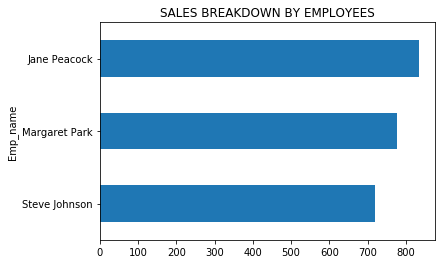

In [10]:
emp_sale = run_query(agent_sale)
emp_sale.set_index("Emp_name",drop=True,inplace=True)

#Plot data using a bar plot
ax = emp_sale.plot(kind = 'barh', y = 'Sale', title = 'SALES BREAKDOWN BY EMPLOYEES', legend = False)    

While there is a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee), the difference roughly corresponds with the differences in their hiring dates.

### Analyzing Sales by Country
We need to collate data on purchases from different countries. For each country, include:
1. total number of customers
2. total value of sales
3. average value of sales per customer
4. average order value

In [11]:
#Total and average sales for each country
country_wise_sales = '''WITH cust_country_sales AS
(
SELECT CASE WHEN
    (SELECT count(*) from customers where country = c.country) = 1 THEN 'Other' else c.country END as country,
    c.customerid, i.*
FROM customers c 
    INNER JOIN invoices i ON c.customerid = i.customerid
)

SELECT 
country,
total_customers,
total_value_of_sales,
avg_sales_per_cust
FROM
(SELECT 
    cust.country country,
    count(*) total_customers,
    SUM(cust.total) total_value_of_sales,
    SUM(cust.total) / count(cust.customerid) avg_sales_per_cust,
    CASE
        WHEN cust.country = "Other" THEN 1
        ELSE 0
    END AS sort
FROM cust_country_sales cust
GROUP BY 1
ORDER BY sort ASC, total_customers DESC)'''

run_query(country_wise_sales)

,country,total_customers,total_value_of_sales,avg_sales_per_cust
0,USA,91,523.06,5.747912
1,Canada,56,303.96,5.427857
2,Brazil,35,190.10,5.431429
3,France,35,195.10,5.574286
4,Germany,28,156.48,5.588571
5,United Kingdom,21,112.86,5.374286
6,Czech Republic,14,90.24,6.445714
7,Portugal,14,77.24,5.517143
8,India,13,75.26,5.789231
9,Other,105,604.30,5.755238


In [12]:
country_sales = run_query(country_wise_sales)
country_sales.set_index("country", drop=True, inplace=True)

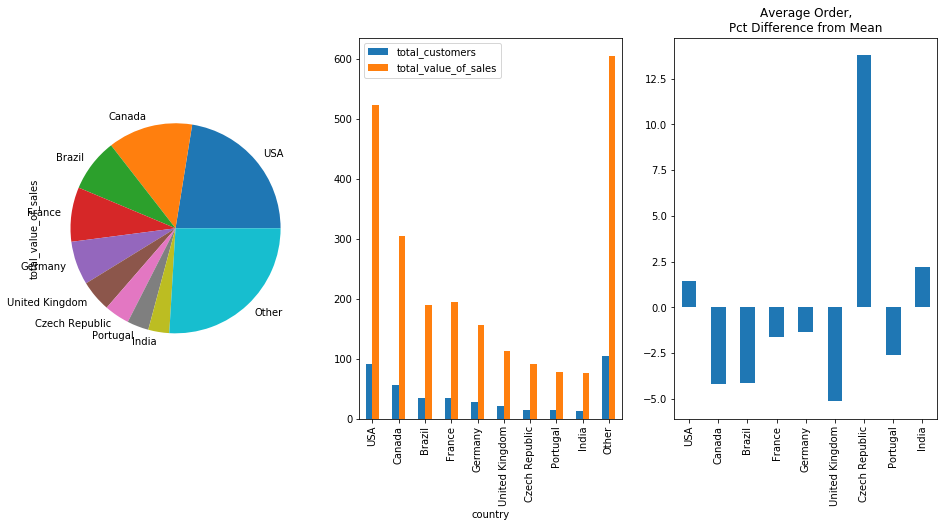

In [13]:
#Plot data
fig, axes = plt.subplots(1,3, figsize = (16,7))
plt.subplots_adjust(hspace = 0.2)
country_sales.plot(kind = 'pie', y = 'total_value_of_sales', ax = axes[0], legend = False)
country_sales.plot(kind = 'bar', y = ['total_customers', 'total_value_of_sales'], ax = axes[1])

avg_order = country_sales["avg_sales_per_cust"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot(kind='bar', ax=axes[2], title="Average Order,\nPct Difference from Mean")

Based on the data, there may be opportunity in the following countries:
1. Czech Republic
2. USA
3. India

It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

### Albums vs Individual Tracks
The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:
1. purchase a whole album
2. purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

In [14]:
#Categorize each invoice as either an album purchase or not, and calculate Number of invoices and Percentage of invoices
album_invoice = '''WITH invoice_first_track AS
    (
     SELECT
         il.invoiceid invoice_id,
         MIN(il.trackid) first_track_id
     FROM invoice_items il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoices
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.trackid FROM tracks t
                  WHERE t.albumid = (
                                      SELECT t2.albumid FROM tracks t2
                                      WHERE t2.trackid = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.trackid FROM invoice_items il2
                  WHERE il2.invoiceid = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.trackid FROM invoice_items il2
                  WHERE il2.invoiceid = ifs.invoice_id

                  EXCEPT 

                  SELECT t.trackid FROM tracks t
                  WHERE t.albumid = (
                                      SELECT t2.albumid FROM tracks t2
                                      WHERE t2.trackid = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase; '''

run_query(album_invoice)

,album_purchase,number_of_invoices,percent
0,no,410,0.995146
1,yes,2,0.004854


Album purchases account for 0.4% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.

### Top 10 Artists most Popular in Playlists
Which artists are used the most in playlists? 

In [15]:
artists_playlist_count = '''WITH artists_tracks AS
(
SELECT p.name, t.trackid, t.albumid FROM tracks t 
            INNER JOIN playlist_track pt ON t.trackid = pt.trackid
            INNER JOIN playlists p ON pt.playlistid = p.playlistid
)
SELECT 
    a.name artist,
    count(at.name) num_of_playlists
    FROM artists_tracks at
    INNER JOIN albums ab ON at.albumid = ab.albumid
    INNER JOIN artists a ON ab.artistid = a.artistid
    GROUP BY 1
    ORDER BY 2 DESC LIMIT 10'''
run_query(artists_playlist_count)

,artist,num_of_playlists
0,Iron Maiden,516
1,U2,333
2,Metallica,296
3,Led Zeppelin,252
4,Deep Purple,226
5,Lost,184
6,Pearl Jam,177
7,Eric Clapton,145
8,Faith No More,145
9,Lenny Kravitz,143


Iron Maiden is by far the most popular artist in playlists.

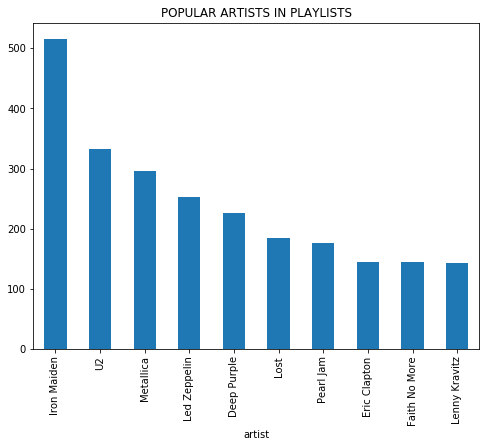

In [16]:
top_10_artists_in_playlists = run_query(artists_playlist_count)
top_10_artists_in_playlists.set_index("artist",drop=True,inplace=True)

#Plot data using a bar plot
ax = top_10_artists_in_playlists.plot(kind = 'bar', figsize = (8,6), title = 'POPULAR ARTISTS IN PLAYLISTS', legend = False)

### Top 10 Highest Selling Artists in US
Which are the highest selling artists in US?

In [17]:
artists_sale = '''WITH artists_invoice AS
(
SELECT a.name, i.trackid, i.invoiceid, i.invoicelineid FROM tracks t 
            INNER JOIN invoice_items i ON t.trackid = i.trackid
            INNER JOIN albums ab ON t.albumid = ab.albumid
            INNER JOIN artists a ON ab.artistid = a.artistid
)
SELECT 
    ai.name artist,
    count(*) num_of_purchases
    FROM artists_invoice ai
    GROUP BY 1
    ORDER BY 2 DESC LIMIT 10'''
run_query(artists_sale)

,artist,num_of_purchases
0,Iron Maiden,140
1,U2,107
2,Metallica,91
3,Led Zeppelin,87
4,Os Paralamas Do Sucesso,45
5,Deep Purple,44
6,Faith No More,42
7,Lost,41
8,Eric Clapton,40
9,R.E.M.,39


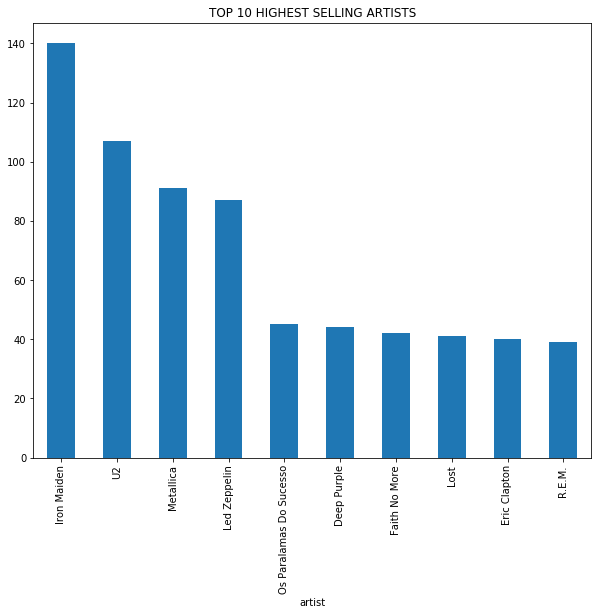

In [18]:
top_10_artists_sale = run_query(artists_sale)
top_10_artists_sale.set_index("artist",drop=True,inplace=True)

#Plot data using a bar plot
ax = top_10_artists_sale.plot(kind = 'bar', figsize = (10,8), title = 'TOP 10 HIGHEST SELLING ARTISTS', legend = False)

Iron Maiden has 140 purchaces with a considerable difference between the second highest selling artist U2 with 107 albums.

### Tracks purchased vs. not purchased
How many tracks have been purchased atleast once?

In [19]:
track_purchase = '''WITH track_invoice AS
(
SELECT t.trackid,
    count(i.invoiceid) tracks_purchased
    FROM tracks t
    LEFT JOIN invoice_items i ON t.trackid = i.trackid
    GROUP BY 1
)
SELECT ti.trackid, 
       CASE WHEN ti.tracks_purchased = 0 
           THEN 0
           ELSE 1
        END purchased
       FROM track_invoice ti'''
tracks_invoice = run_query(track_purchase)
p = tracks_invoice['purchased'].sum()/len(tracks_invoice['trackid'])
print(p*100,"% of tracks have been purchased at least once.")

56.63716814159292 % of tracks have been purchased at least once.


### Range of Tracks In the Store and Their Sales Popularity
What is the range of tracks in the store and their sales popularity?

In [20]:
track_sales = '''WITH tracks_sold AS
(
SELECT g.name,  
       i.invoiceid,
       t.trackid
       FROM genres g 
       LEFT JOIN tracks t ON g.genreid = t.genreid
       LEFT JOIN invoice_items i ON t.trackid = i.trackid
)
SELECT ts.name, 
       count(ts.invoiceid) tracks_sold,
       count(ts.trackid) tracks_available,
       count(ts.trackid) - count(ts.invoiceid) availability
       FROM tracks_sold ts
       GROUP BY 1'''

run_query(track_sales)

,name,tracks_sold,tracks_available,availability
0,Alternative,14,40,26
1,Alternative & Punk,244,373,129
2,Blues,61,89,28
3,Bossa Nova,15,16,1
4,Classical,41,79,38
5,Comedy,9,18,9
6,Drama,29,66,37
7,Easy Listening,10,24,14
8,Electronica/Dance,12,31,19
9,Heavy Metal,12,28,16


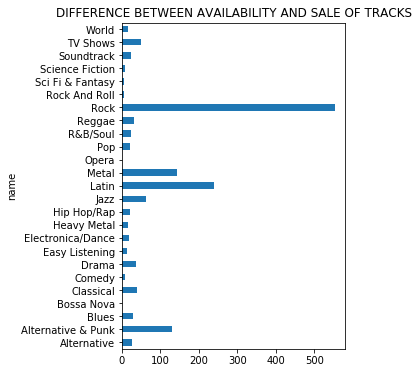

In [21]:
tracks_sold_df = run_query(track_sales)
tracks_sold_df.set_index("name",drop=True,inplace=True)

#Plot data using a bar plot
ax = tracks_sold_df.plot(kind = 'barH', y = 'availability', figsize = (4,6), title = 'DIFFERENCE BETWEEN AVAILABILITY AND SALE OF TRACKS', legend = False)


Higher is the difference, more is the deficit between demand and supply for track of that genre. The result shows the range of the tracks is not closely reflective of popularity. For example, there are more tracks of Latin and Rock music than it can sell. It is recommended to look into the selections of tracks in these particular types as some of the currect selections are not popular with the customer.

### Protected vs Non-protected Media Types and Popularity
How does popularity vary for protected vs non-protected media types?

In [22]:
media_types_popularity = '''WITH track_media_sale AS
(
SELECT i.invoiceid,
       t.name,
       CASE
         WHEN mt.name LIKE '%protected%' THEN 1
         ELSE 0
     END AS protected
       FROM invoice_items i
       INNER JOIN tracks t ON i.trackid = t.trackid
       INNER JOIN media_types mt ON t.mediatypeid = mt.mediatypeid
)
SELECT tms.protected,
        count(tms.invoiceid) as count
        FROM track_media_sale tms
        GROUP BY 1'''
run_query(media_types_popularity)

,protected,count
0,0,1983
1,1,257


Unprotected media types sell more than protected media types.

### Conclusion
We worked on answering different business quesion and found that:

1. Analyzing US genre sales, new albums by Red Tone (Punk), Slim Jim Bites (Blues) and Meteor and the Girls (Pop) should be purchased. Rock and Latin can be considered for future purchases because of high popularity.
2. While there is a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee), the difference roughly corresponds with the differences in their hiring dates.
3. Czech Republic, USA and India have good opportunity for sales. As the sample size is not large enough to give us high confidence, starting off with small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers would be a good idea.
4. Album purchases is recommended instead of purchasing only select tracks from albums.
5. Iron Maiden is by far the most popular artist in playlists and has the maximum number of purchases.
6. 56.63% of tracks have been purchased at least once.
7. The available range of tracks is not closely reflective of popularity. There are more tracks of Latin and Rock music than it can sell. It is recommended to look into the selections of tracks in these particular types as some of the currect selections are not popular with the customer.
8. Unprotected media types sell more than protected media types.